In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import chefboost as chef

import warnings

In [2]:
housing_data = pd.read_csv('DatenAusgegeben1.2_UTF8_manuell.csv', sep=";", keep_default_na=False)

warnings.filterwarnings('ignore')

# Bereinigung und Feature Engeneering

# für €/qm² für besseren Vergleich der Daten
housing_data["Preisproqm"] = housing_data["Preis"]/housing_data["Wohnflaeche in qm"]

# monate seit 2136
housing_data["Monate"] = (housing_data["Verkaufsjahr"]-2136)*12 + housing_data["Verkaufsmonat"] -1

# Werte der Heizungsqualitaet in Zahlen umwandeln
housing_data["Heizungsqualitaet"] = [1 if x=="Schl" else 2 if x=="Ud" else 3 if x=="Ty" else 4 if x=="Gut" else 5 for x in housing_data["Heizungsqualitaet"]]

# Zustand, 1-10 wird auf 1-5 gemapt, das ist zwar ein bisschen ungenauer, aber einfacher zu vergleichen
housing_data["Zustandf"] = [int(x/2) + x%2 for x in housing_data["Zustand"]]

# Alle Zustände werden von 1...X auf 0....X-1 geschoben
housing_data["HeizungsqualitaetN"] = [ x-1 for x in housing_data["Heizungsqualitaet"]]
housing_data["ZustandN"] = [ x-1 for x in housing_data["Zustandf"]]
housing_data["FassadeN"] = [ x-1 for x in housing_data["Zustand Fassade"]]
housing_data["KuecheN"] = [ x-1 for x in housing_data["Kuechenqualitaet"]]

# Klimaanlage Ja/Nein  -> 1/0
housing_data["Klimaanlage"] = [1 if x == "Y" else 0 for x in housing_data["Klimaanlage"]]

# Besonders Große Daten beim Preis + Wohnfläche in qm rausschmeißen
max_value = housing_data["Preis"].unique()[-1:][0]
housing_data[housing_data["Preis"] != max_value]

max_value = housing_data["Wohnflaeche in qm"].unique()[-1:][0]
housing_data[housing_data["Wohnflaeche in qm"] != max_value]

max_value = housing_data["Grundstueck in qm"].unique()[-2:][0]
housing_data[housing_data["Grundstueck in qm"] != max_value]


# NA in Garage Typ wird zu "Keine Garage"
housing_data["Garage Typ"] = ['keine Garage' if x=='NA' else x for x in housing_data["Garage Typ"]]


print(housing_data.keys())

Index(['Grundstueck in qm', 'Grundstuecksform', 'Steigung', 'Bezirk', 'Zone',
       'Lage', 'Typ', 'Zustand', 'Gebaut', 'Renoviert', 'Zustand Fassade',
       'Kellerflaeche in qm', 'Heizung', 'Heizungsqualitaet', 'Klimaanlage',
       'Erster Stock in qm', 'Zweiter Stock in qm', 'Wohnflaeche in qm',
       'Schlafzimmer', 'Kuechen', 'Kuechenqualitaet', 'Raeume', 'Garage Typ',
       'Garagenkapazitaet', 'Pool', 'Verkaufsmonat', 'Verkaufsjahr', 'Preis',
       'Preisproqm', 'Monate', 'Zustandf', 'HeizungsqualitaetN', 'ZustandN',
       'FassadeN', 'KuecheN'],
      dtype='object')


In [3]:
#Extract X and y from dataset
# Set features to test
features = [ "Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN","Klimaanlage", "Gebaut", "Garagenkapazitaet", "HeizungsqualitaetN", "Raeume"]
# Predictvalue
predict= "Preis"

X = {}
for feature in features:
    X[feature] = housing_data[feature]
X = pd.DataFrame(X)

Y = pd.DataFrame(housing_data[predict])

In [4]:
# K-Fold Poly Regression
split = 10
Kfold = KFold(n_splits=split)
kfold = Kfold.split(X, Y)
scoresr = []
scoresl = []
scoresri = []
reg = [None]*split
lasso = [None]*split
ridge = [None]*split

for k, (train, test) in enumerate(kfold):
    
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(X.iloc[train, :])
    poly.fit(X.iloc[train, :], Y.iloc[train])
    x_poly_test = poly.fit_transform(X.iloc[test, :])
    
    reg[k] = linear_model.LinearRegression()
    reg[k].fit(x_poly, Y.iloc[train])
    scorer = r2_score(reg[k].predict(x_poly_test), Y.iloc[test])
    scoresr.append(scorer)
    
    lasso[k] = linear_model.Lasso()
    lasso[k].fit(x_poly, Y.iloc[train])
    scorel = r2_score(lasso[k].predict(x_poly_test), Y.iloc[test])
    scoresl.append(scorel)
    
    ridge[k] = linear_model.Ridge()
    ridge[k].fit(x_poly, Y.iloc[train])
    scoreri = r2_score(ridge[k].predict(x_poly_test), Y.iloc[test])
    scoresri.append(scoreri)
    
print("Regression:" + str(np.sort(scoresr)[-1:]))
best = scoresr.index(np.sort(scoresr)[-1:])
best_reg = reg[k]

print("LassoRegression:" + str(np.sort(scoresl)[-1:]))
best = scoresl.index(np.sort(scoresl)[-1:])
best_lasso = lasso[k]

print("Regression:" + str(np.sort(scoresri)[-1:]))
best = scoresri.index(np.sort(scoresri)[-1:])
best_ridge = ridge[k]

Regression:[0.87088971]
LassoRegression:[0.8935296]
Regression:[0.88243556]


In [5]:
#"Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN","Klimaanlage", "Gebaut", 
#"Garagenkapazitaet", "HeizungsqualitaetN", "Raeume"]

y = best_lasso.predict(poly.fit_transform([[2000, 160, 4, 4, 1, 2130, 2, 4, 4]]))

y

array([329007.90755583])

In [6]:
# Gradient boosting Tree Regression

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

gradientregressor = GradientBoostingRegressor(max_depth=4, n_estimators=100, learning_rate=0.15, loss="ls")

model = gradientregressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_score(y_pred, y_test)


0.8140745313850475

In [7]:
# Random Forest 
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

forestregressor = RandomForestRegressor(max_depth=10, n_estimators=10, criterion="mse")

model = forestregressor.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_score(y_pred, y_test)

0.7967204584422906

In [8]:
# Stochastic Gradiend Descend Regressor
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

sgdr = SGDRegressor(eta0=0.5)

model = sgdr.fit(X_train, y_train)
y_pred = model.predict(X_test)

r2_score(y_pred, y_test)

-287.41661485354473

In [9]:
#Prepare data

#Most important features 
#air conditioning, heater quality, kitchen quality, state of house, state of facade 

#Encode features (Label or One-Hot)

#Separate into training- and testdata
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)

poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(X_train)
poly.fit(X_train, y_train)


print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
 #Regression

reg = linear_model.LinearRegression()
ridge = linear_model.Ridge(alpha=0.05)
lasso = linear_model.Lasso(alpha=0.05)

reg.fit(x_poly, y_train)
ridge.fit(x_poly, y_train)
lasso.fit(x_poly, y_train)
#Validation
y_pred_reg = reg.predict(poly.fit_transform(X_test))
y_pred_ridge = ridge.predict(poly.fit_transform(X_test))
y_pred_lasso = lasso.predict(poly.fit_transform(X_test))


print(r2_score(y_test, y_pred_reg), mean_squared_error(y_test, y_pred_reg), max_error(y_test, y_pred_reg))
print(r2_score(y_test, y_pred_ridge), mean_squared_error(y_test, y_pred_ridge), max_error(y_test, y_pred_ridge))
print(r2_score(y_test, y_pred_lasso), mean_squared_error(y_test, y_pred_lasso), max_error(y_test, y_pred_lasso))

(1600, 9) (1600, 1) (400, 9) (400, 1)
0.8551244265828083 828170050.3035767 160400.06947118044
0.8688094465893831 749940688.1003717 117610.6218354404
0.8863152105332079 649870337.6334133 139263.3347882768


(array([  1.,   3.,  16.,  96., 185.,  76.,  14.,   5.,   1.,   3.]),
 array([0.32887   , 0.48366682, 0.63846363, 0.79326044, 0.94805726,
        1.10285407, 1.25765088, 1.4124477 , 1.56724451, 1.72204132,
        1.87683814]),
 <BarContainer object of 10 artists>)

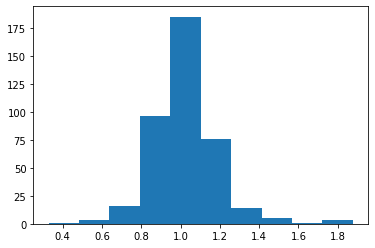

In [10]:
plt.hist(y_pred_reg / y_test)

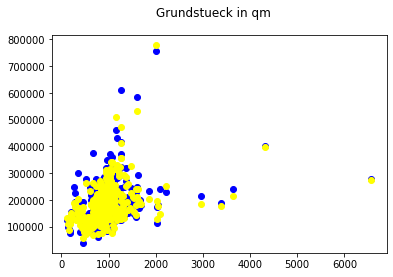

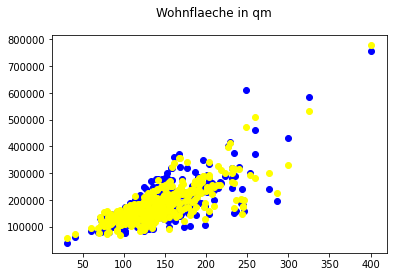

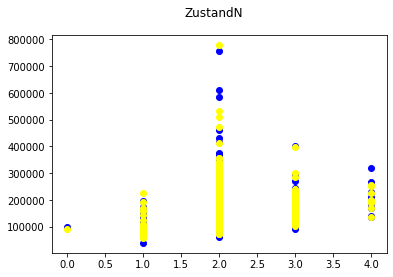

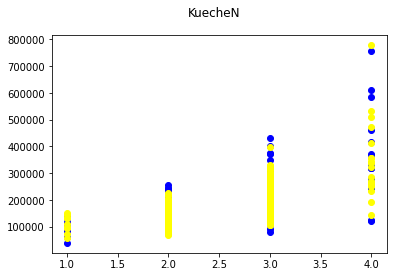

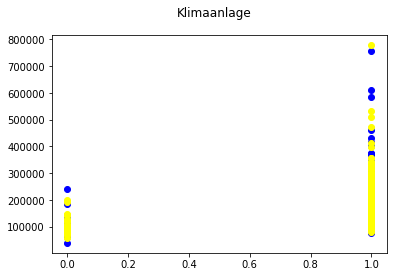

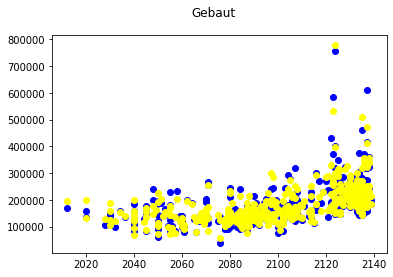

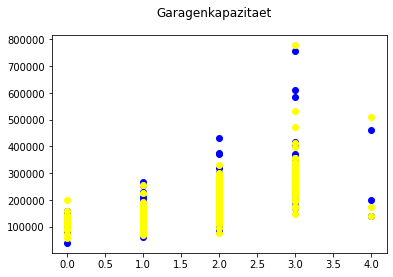

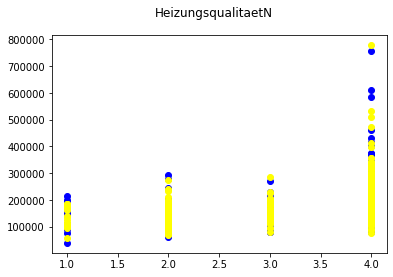

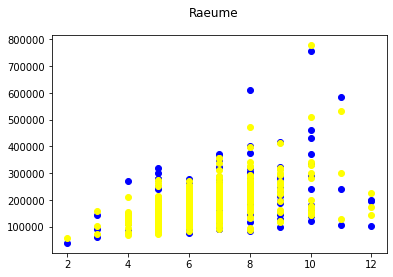

In [11]:
for feature in features:
    plt.scatter(X_test[feature], y_test, c="blue")
    #plt.scatter(X_test[feature], y_pred_reg, c="red")
    #plt.scatter(X_test[feature], y_pred_ridge, c="orange")
    plt.scatter(X_test[feature], y_pred_lasso, c="yellow")
    plt.suptitle(feature)
    plt.show()


In [12]:
#"Grundstueck in qm", "Wohnflaeche in qm","ZustandN","KuecheN","Klimaanlage", "Gebaut", #"Garagenkapazitaet", "HeizungsqualitaetN", "Raeume"]


y = reg.predict(poly.fit_transform([[3000, 180, 4, 4, 1, 2130, 2, 2, 20]]))
y

array([[3100462.8754341]])